In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Data Generation Functions

def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
        
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21, 1)

In [34]:
# Show Result Function
def show_result(x, y, pred_y):
    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
            
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
            
    plt.show()
    


In [222]:
# Utility Functions

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def dsigmoid(x):
    return np.multiply(sigmoid(x), 1.0-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1.0-np.multiply(np.tanh(x), np.tanh(x))

def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)

def identity(z):
    return z

def didentity(z):
    return np.ones_like(z)


In [189]:
# Get Activation Function

def get_act(name):
    if name == 'relu':
        return relu, drelu
    elif name == 'tanh':
        return tanh, dtanh
    elif name == 'sigmoid':
        return sigmoid, dsigmoid
    elif name == 'none':
        return identity, didentity
    else:
        raise ValueError("Unknown activation function:" + name)
    

In [37]:
# NN class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lr = 0.1, optimizer = "sgd", act_hidden = "relu", act_output = "sigmoid", momentum = 0.9, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        self.input_size = input_size
        self.lr = lr
        self.optimizer = optimizer
        self.momentum_coef = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.adam_t = 0
        
        self.hidden_act, self.hidden_dact = get_act(act_hidden)
        self.output_act, self.output_dact = get_act(act_output)
        
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2.0/input_size) 
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2.0/hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2.0/hidden_size2)
        self.b3 = np.zeros((1, output_size))
        
        if self.optimizer == "momentum":
            self.vW1 = np.zeros_like(self.W1)
            self.vb1 = np.zeros_like(self.b1)
            self.vW2 = np.zeros_like(self.W2)
            self.vb2 = np.zeros_like(self.b2)
            self.vW3 = np.zeros_like(self.W3)
            self.vb3 = np.zeros_like(self.b3)
        elif self.optimizer == "adam":
            self.amW1 = np.zeros_like(self.W1)
            self.avW1 = np.zeros_like(self.W1)
            self.amb1 = np.zeros_like(self.b1)
            self.avb1 = np.zeros_like(self.b1)
            self.amW2 = np.zeros_like(self.W2)
            self.avW2 = np.zeros_like(self.W2)
            self.amb2 = np.zeros_like(self.b2)
            self.avb2 = np.zeros_like(self.b2)
            self.amW3 = np.zeros_like(self.W3)
            self.avW3 = np.zeros_like(self.W3)
            self.amb3 = np.zeros_like(self.b3)
            self.avb3 = np.zeros_like(self.b3)
            
    def forward(self, x):
        # First Hidden Layer
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.hidden_act(self.z1)
        # Second Hidden Layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.hidden_act(self.z2)
        # Output Layer
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.output_act(self.z3)
        
        return self.a3
    
    def loss_function(self, y, y_pred):
        m = y.shape[0]
        return -np.sum(y * np.log(y_pred + 1e-8) + (1-y)*np.log(1-y_pred + 1e-8))/m
    
    def backward(self, X, y):
        m = y.shape[0]
        if (self.output_act == sigmoid):
            dz3 = self.a3 - y
        else:
            dz3 = (self.a3 - y) * self.output_dact(self.z3)
            
        dW3 = np.dot(self.a2.T, dz3)/m
        db3 = np.sum(dz3, axis=0, keepdims=True)/m
        
        # Back Propagation for Second Hidden Layer
        da2 = np.dot(dz3, self.W3.T)
        dz2 = da2 * self.hidden_dact(self.z2)
        dW2 = np.dot(self.a1.T, dz2)/m
        db2 = np.sum(dz2, axis=0, keepdims=True)/m
            
        # Back Propagation for First Hidden Layer
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.hidden_dact(self.z1)
        dW1 = np.dot(X.T, dz1)/m
        db1 = np.sum(dz1, axis=0, keepdims=True)/m
        
        # Update Weights and Biases
        if self.optimizer == "sgd":
            self.W3 -= self.lr * dW3
            self.b3 -= self.lr * db3
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            
        elif self.optimizer == "momentum":
            self.vW3 = self.momentum_coef * self.vW3 - self.lr * dW3
            self.vb3 = self.momentum_coef * self.vb3 - self.lr * db3
            self.W3 += self.vW3
            self.b3 += self.vb3
            
            self.vW2 = self.momentum_coef * self.vW2 - self.lr * dW2
            self.vb2 = self.momentum_coef * self.vb2 - self.lr * db2
            self.W2 += self.vW2
            self.b2 += self.vb2
            
            self.vW1 = self.momentum_coef * self.vW1 - self.lr * dW1
            self.vb1 = self.momentum_coef * self.vb1 - self.lr * db1
            self.W1 += self.vW1
            self.b1 += self.vb1
        
        elif self.optimizer == "adam":
            self.adam_t += 1
            self.amW3 = self.beta1 * self.amW3 + (1 - self.beta1) * dW3
            self.avW3 = self.beta2 * self.avW3 + (1 - self.beta2) * (dW3**2)
            amW3_hat = self.amW3 / (1 - self.beta1**self.adam_t)
            avW3_hat = self.avW3 / (1 - self.beta2**self.adam_t)
            self.W3 -= self.lr * amW3_hat / (np.sqrt(avW3_hat) + self.epsilon)
            
            self.amb3 = self.beta1 * self.amb3 + (1 - self.beta1) * db3
            self.avb3 = self.beta2 * self.avb3 + (1 - self.beta2) * (db3**2)
            amb3_hat = self.amb3 / (1 - self.beta1**self.adam_t)
            avb3_hat = self.avb3 / (1 - self.beta2**self.adam_t)
            self.b3 -= self.lr * amb3_hat / (np.sqrt(avb3_hat) + self.epsilon)
            
            self.amW2 = self.beta1 * self.amW2 + (1 - self.beta1) * dW2
            self.avW2 = self.beta2 * self.avW2 + (1 - self.beta2) * (dW2**2)
            amW2_hat = self.amW2 / (1 - self.beta1**self.adam_t)
            avW2_hat = self.avW2 / (1 - self.beta2**self.adam_t)
            self.W2 -= self.lr * amW2_hat / (np.sqrt(avW2_hat) + self.epsilon)
            
            self.amb2 = self.beta1 * self.amb2 + (1 - self.beta1) * db2
            self.avb2 = self.beta2 * self.avb2 + (1 - self.beta2) * (db2**2)
            amb2_hat = self.amb2 / (1 - self.beta1**self.adam_t)
            avb2_hat = self.avb2 / (1 - self.beta2**self.adam_t)
            self.b2 -= self.lr * amb2_hat / (np.sqrt(avb2_hat) + self.epsilon)
            
            self.amW1 = self.beta1 * self.amW1 + (1 - self.beta1) * dW1
            self.avW1 = self.beta2 * self.avW1 + (1 - self.beta2) * (dW1**2)
            amW1_hat = self.amW1 / (1 - self.beta1**self.adam_t)
            avW1_hat = self.avW1 / (1 - self.beta2**self.adam_t)
            self.W1 -= self.lr * amW1_hat / (np.sqrt(avW1_hat) + self.epsilon)
            
            self.amb1 = self.beta1 * self.amb1 + (1 - self.beta1) * db1
            self.avb1 = self.beta2 * self.avb1 + (1 - self.beta2) * (db1**2)
            amb1_hat = self.amb1 / (1 - self.beta1**self.adam_t)
            avb1_hat = self.avb1 / (1 - self.beta2**self.adam_t)
            self.b1 -= self.lr * amb1_hat / (np.sqrt(avb1_hat) + self.epsilon)
            
        else:
            raise ValueError("Unknown optimizer:" + self.optimizer)
        
    def train(self, X, y, epochs = 1000):
        loss_rec = []
        for e in range(epochs):
            y_pred = self.forward(X)
            loss = self.loss_function(y, y_pred)
            loss_rec.append(loss)
            self.backward(X, y)
            if (e+1) % 100 == 0:
                print("epoch ", e+1, " loss : ", loss)
                
        return loss_rec
        

In [ ]:
# Generate Data, Construct NN and Train it
#X, y = generate_linear(n=100)
X, y = generate_XOR_easy()
nn = NeuralNetwork(
    input_size = 2,
    hidden_size1 = 8,
    hidden_size2 = 8,
    output_size = 1,
    lr = 0.1,
    # Available optimizer : sgd, momentum, adam
    optimizer = "momentum",
    # Available activation function : relu, tanh, sigmoid
    act_hidden = "relu",
    act_output = "sigmoid"
)
    
loss_rec = nn.train(X, y, epochs = 1000)
    

epoch  100  loss :  0.6889864249034342
epoch  200  loss :  0.682197586178822
epoch  300  loss :  0.6515820945964798
epoch  400  loss :  0.49014759466060104
epoch  500  loss :  0.23334024579060608
epoch  600  loss :  0.11371601400381229
epoch  700  loss :  0.06035678957170123
epoch  800  loss :  0.03666859539454853
epoch  900  loss :  0.02505953264456033
epoch  1000  loss :  0.018591848841342063


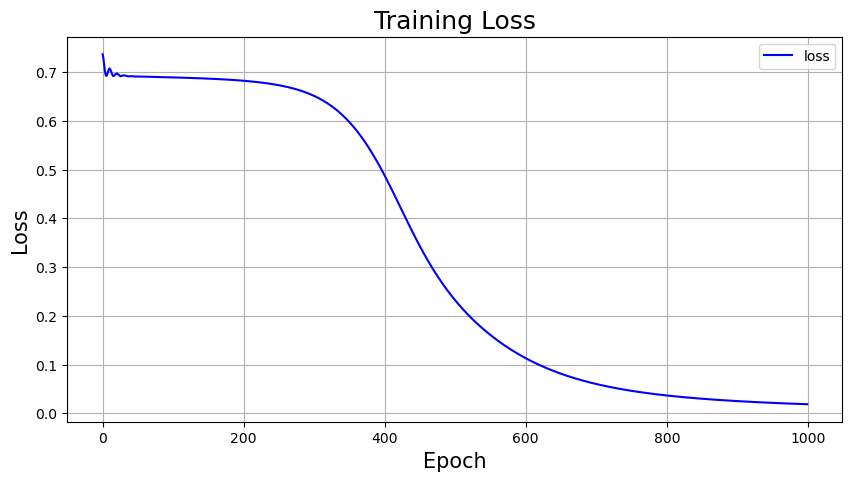

In [224]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(loss_rec, label = "loss", color = 'blue')
plt.title("Training Loss", fontsize=18)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid(True)
plt.show()




Iter0 |     Ground truth: 0 |     prediction: 0.0126 |
Iter1 |     Ground truth: 1 |     prediction: 0.9994 |
Iter2 |     Ground truth: 0 |     prediction: 0.0143 |
Iter3 |     Ground truth: 1 |     prediction: 0.9993 |
Iter4 |     Ground truth: 0 |     prediction: 0.0162 |
Iter5 |     Ground truth: 1 |     prediction: 0.9991 |
Iter6 |     Ground truth: 0 |     prediction: 0.0178 |
Iter7 |     Ground truth: 1 |     prediction: 0.9978 |
Iter8 |     Ground truth: 0 |     prediction: 0.0190 |
Iter9 |     Ground truth: 1 |     prediction: 0.9133 |
Iter10 |     Ground truth: 0 |     prediction: 0.0195 |
Iter11 |     Ground truth: 0 |     prediction: 0.0194 |
Iter12 |     Ground truth: 1 |     prediction: 0.9393 |
Iter13 |     Ground truth: 0 |     prediction: 0.0188 |
Iter14 |     Ground truth: 1 |     prediction: 0.9881 |
Iter15 |     Ground truth: 0 |     prediction: 0.0179 |
Iter16 |     Ground truth: 1 |     prediction: 0.9895 |
Iter17 |     Ground truth: 0 |     prediction: 0.0168 |
It

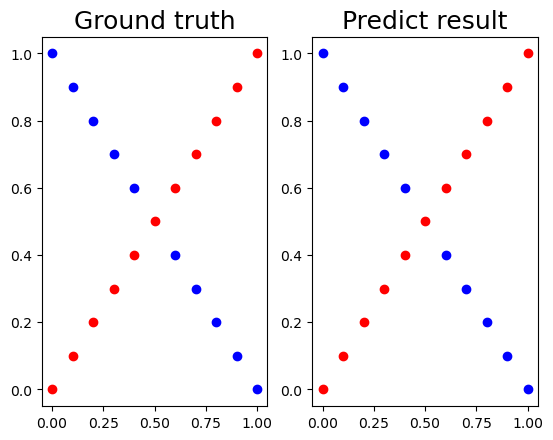

In [225]:
# Test
y_pred = nn.forward(X)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate the final loss on this dataset
final_loss = nn.loss_function(y, y_pred)
# Calculate accuracy
accuracy = np.mean(y_pred_labels == y)


for i in range(X.shape[0]):
    print(f"Iter{i} |     Ground truth: {y[i][0]} |     prediction: {y_pred[i][0]:.4f} |")
    
print(f"loss={final_loss:.5f} accuracy={accuracy * 100:.2f}%")
show_result(X, y, y_pred_labels)